# Chapter 13. Loading and Preprocessing Data with TensorFlow

project goal: Data API, TFRecord TF Transform, TF Datasets

# Data API

In [22]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
np.random.seed(42)

In [18]:
# from_tensor_slices() 會將接收的X建立 tf.data.Dataset, 所有元素都是X的切片 
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
print(dataset, "\n")
print("Inside dataset:")
for item in dataset:
    print(item)           # 所以 dataset 裡面是 tensor 0, 1, 2, ..., 9

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)> 

Inside dataset:
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [20]:
# 可以對於 dataset 做一些操作
# 注意: dataset的method不會修改原來資料組, 而是建立新的資料組去操作！

# .repeat(3).batch(7) 代表 在新的資料集中將資料重複串接三次, 再將每7個分成一組
dataset = dataset.repeat(3).batch(7)
# 輸出會是：
# tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
# tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
# tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
# tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
# tf.Tensor([8 9], shape=(2,), dtype=int32)

# map() 可以用來轉換項目
dataset = dataset.map(lambda x: x * 2)
# 輸出會是每一項都乘上2:
# tf.Tensor([ 0  4  8 12 16 20 24], shape=(7,), dtype=int32)
# tf.Tensor([28 32 36  0  4  8 12], shape=(7,), dtype=int32)
# tf.Tensor([16 20 24 28 32 36  0], shape=(7,), dtype=int32)
# tf.Tensor([ 4  8 12 16 20 24 28], shape=(7,), dtype=int32)
# tf.Tensor([32 36], shape=(2,), dtype=int32)

# unbatch() 將dataset拆開成單獨一項
dataset = dataset.unbatch()

# 或是用 filter() 來過濾資料組
dataset = dataset = dataset.filter(lambda x: x < 10)

# 以及 shuffle() 將實例洗亂
tf.random.set_seed(42)
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=3, seed=42).batch(7)
print("After shuffle:")
for item in dataset:
    print(item)

After shuffle:
tf.Tensor([1 3 0 4 2 5 6], shape=(7,), dtype=int64)
tf.Tensor([8 7 1 0 3 2 5], shape=(7,), dtype=int64)
tf.Tensor([4 6 9 8 9 7 0], shape=(7,), dtype=int64)
tf.Tensor([3 1 4 5 2 8 7], shape=(7,), dtype=int64)
tf.Tensor([6 9], shape=(2,), dtype=int64)


# 範例1. Split the California dataset to multiple CSV files

In [21]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42
)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

通常在處理沒辦法存進memory的大型資料時, 我們會先將其分成很多個file, 再讓tensorflow去平行讀取他們

In [23]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

# 經過上面的轉換後, training dataset 被分配到20個csv file中,
# validation & testing dataset 也各自被分配到10個csv file中
# 而他們都存在資料夾 datasets 裡面

In [25]:
import pandas as pd
pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


In [26]:
# 建立 input 的 pipeline
# interleave() 可以一次讀取 cycle_length 個檔案, 並讓他們的資料交錯排列
# skip(1)代表跳過檔案的第一row (標頭列)

filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers
)

In [27]:
# 首先, preprocessing
# 前面已經計算過 X_mean 及 X_std, 他們都是1D tensor, 裡面有8個浮點數(每個輸入特徵一個)

n_inputs = 8

@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    # decode_csv(要解析的列, 含有各欄default值的array)
    # 所以 defs 告訴他, 各特徵欄都是浮點數0, 而最後一欄(target的預設值)是沒有預設值的浮點數
    fields = tf.io.decode_csv(line, record_defaults=defs)
    # 因為decode_csv的回傳值會是每欄一個的list, 所以用tf.stack把他疊成1D tensor
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [28]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000, 
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads
    )
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

# 上述method的流程：
# 載入所有csv並重複n次(這裡是1), interleave()一次讀取多個檔案並交錯排列, shuffle()洗亂
# map()做preprocess, 最後batch將他們分批

prefetch: 讓GPU在處理某一個batch時, 就平行讓CPU先從dataset準備好下一個batch, 可以大幅提升性能！

In [29]:
# 開始建立 dataset & 執行 preprocess
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=valid_set)

Epoch 1/10
362/362 [==============================] - 1s 924us/step - loss: 2.3284 - val_loss: 9.1637
Epoch 2/10
362/362 [==============================] - 0s 1ms/step - loss: 1.0345 - val_loss: 0.9127
Epoch 3/10
362/362 [==============================] - 0s 782us/step - loss: 0.7136 - val_loss: 0.7135
Epoch 4/10
362/362 [==============================] - 0s 852us/step - loss: 0.6939 - val_loss: 0.6446
Epoch 5/10
362/362 [==============================] - 0s 731us/step - loss: 0.6604 - val_loss: 0.6862
Epoch 6/10
362/362 [==============================] - 0s 688us/step - loss: 0.6222 - val_loss: 0.6997
Epoch 7/10
362/362 [==============================] - 0s 684us/step - loss: 0.5914 - val_loss: 0.5534
Epoch 8/10
362/362 [==============================] - 0s 674us/step - loss: 0.5865 - val_loss: 0.5276
Epoch 9/10
362/362 [==============================] - 0s 656us/step - loss: 0.5439 - val_loss: 0.5085
Epoch 10/10
362/362 [==============================] - 0s 686us/step - loss: 0.5111 

In [30]:
# evaluation
model.evaluate(test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 575us/step - loss: 0.5066


0.5065754652023315

In [31]:
# predict
new_set = test_set.map(lambda X, y: X)     # 把 y(label) 拿掉來預測
X_new = X_test
model.predict(new_set, steps=len(X_new) // batch_size)

161/161 [==============================] - 0s 672us/step


array([[2.515468 ],
       [1.1707823],
       [3.0246022],
       ...,
       [2.0176928],
       [1.6959119],
       [2.1857405]], dtype=float32)

In [ ]:
# 也可以自己寫train, 再轉成 tf.function 加速！

optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

In [32]:
# 其他可以用於 dataset 的函式
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● choose_from_datasets()Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● counter()            Creates a `Dataset` that counts from `start` in steps of size `step`.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()        

# TFRecord binary format

TFRecord 是高速儲存與讀取大量資料時的最佳TensorFlow格式

In [ ]:
# create & write
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

# read parallelly & print
filepaths = ["my_data_{}.tfrecord".format(i) for i in range(5)]
dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

# compress files
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

# read the compressed files & print
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"], 
                                  compression_type="GZIP")
for item in dataset:
    print(item)

protocol buffer (protobuf, 協定緩衝區): 一種高效的二進制格式

In [ ]:
# 以下這段要用protobuf compiler才能跑, 只是示範而已！

# 先定義 protobuf:
%%writefile person.proto
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}

# compile
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

# import & 使用
from person_pb2.py import Person

person = Person(name="Al", id=123, email=["a@b.com"])
print(person)
# output會是:
# name: "Al"
# id: 123
# email: "a@b.com"

In [36]:
# 而 TensorFlow Protobuf 使用取來會是這樣:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }))

with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

Github上面還有更多關於protobuf的操作, 可以參考一下

回到 California housing dataset, 開始正式做 proprocessing：

In [39]:
def load_housing_data(housing_path="./datasets/housing/"):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
    
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [43]:
housing_median_age = tf.feature_column.numeric_column("housing_median_age")

# normalize "housing_median_age" column
age_mean, age_std = X_mean[1], X_std[1]
housing_median_age = tf.feature_column.numeric_column(
    "housing_median_age", normalizer_fn=lambda x: (x - age_mean) / age_std)

# bucketize "median income" column
# bucketize可以想成把各個元素放到boundary桶子中, default會是每個桶子中都是小於等於該數字的元素
median_income = tf.feature_column.numeric_column("median_income")
bucketized_income = tf.feature_column.bucketized_column(
    median_income, boundaries=[1.5, 3., 4.5, 6.]
)
print(bucketized_income)
# BucketizedColumn(source_column=NumericColumn(key='median_income', 
#                  shape=(1,), default_value=None, dtype=tf.float32, 
#                  normalizer_fn=None), boundaries=(1.5, 3.0, 4.5, 6.0))

# 把 ocean_proximity 利用 hash映射 轉成 one-hot encoding
ocean_prox_vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list(
    "ocean_proximity", ocean_prox_vocab)
ocean_proximity_one_hot = tf.feature_column.indicator_column(ocean_proximity)
ocean_proximity_embed = tf.feature_column.embedding_column(ocean_proximity,
                                                           dimension=2)

# bucketize "housing_median_age" column
bucketized_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=[-1., -0.5, 0., 0.5, 1.])    # age was scaled

# 交叉後的特徵拿去做 hash
age_and_ocean_proximity = tf.feature_column.crossed_column(
    [bucketized_age, ocean_proximity], hash_bucket_size=100)

# bucketize "latitude" column
latitude = tf.feature_column.numeric_column("latitude")
bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=list(np.linspace(32., 42., 20 - 1)))

# bucketize "longitude" column
longitude = tf.feature_column.numeric_column("longitude")
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=list(np.linspace(-125., -114., 20 - 1)))

# 交叉後的特徵拿去做 hash
location = tf.feature_column.crossed_column(
    [bucketized_latitude, bucketized_longitude], hash_bucket_size=1000)


BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.5, 3.0, 4.5, 6.0))
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Instructions for updating:
Use `tf.keras.layers.experimental.preprocessing.HashedCrossing` instead for feature crossing when preprocessing data to train a Keras model.


Instructions for updating:
Use `tf.keras.layers.experimental.preprocessing.HashedCrossing` instead for feature crossing when preprocessing data to train a Keras model.


In [ ]:
median_house_value = tf.feature_column.numeric_column("median_house_value")
columns = [housing_median_age, median_house_value]
feature_descriptions = tf.feature_column.make_parse_example_spec(columns)

with tf.io.TFRecordWriter("my_data_with_features.tfrecords") as f:
    for x, y in zip(X_train[:, 1:2], y_train):
        example = Example(features=Features(feature={
            "housing_median_age": Feature(float_list=FloatList(value=[x])),
            "median_house_value": Feature(float_list=FloatList(value=[y]))
        }))
        f.write(example.SerializeToString())

def parse_examples(serialized_examples):
    examples = tf.io.parse_example(serialized_examples, feature_descriptions)
    targets = examples.pop("median_house_value") # separate the targets
    return examples, targets

batch_size = 32
dataset = tf.data.TFRecordDataset(["my_data_with_features.tfrecords"])
dataset = dataset.repeat().shuffle(10000).batch(batch_size).map(parse_examples)

columns_without_target = columns[:-1]
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns=columns_without_target),
    keras.layers.Dense(1)
])
model.compile(loss="mse",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
model.fit(dataset, steps_per_epoch=len(X_train) // batch_size, epochs=5)

some_columns = [ocean_proximity_embed, bucketized_income]
dense_features = keras.layers.DenseFeatures(some_columns)
dense_features({
    "ocean_proximity": [["NEAR OCEAN"], ["INLAND"], ["INLAND"]],
    "median_income": [[3.], [7.2], [1.]]
})

# 參考：TF Transform

TF Transform 是 TFX (TensorFlow Extended) 的一部分, 將tensorflow model生產化

In [ ]:
import tensorflow_transform as tft

def preprocess(inputs):     # inputs is a batch of input features
    median_age = inputs["housing_median_age"]
    ocean_proximity = inputs["ocean_proximity"]
    standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
    ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
    return {
        "standardized_median_age": standardized_age,
        "ocean_proximity_id": ocean_proximity_id
    }

# TensorFlow Datasets

2024-01-03 16:44:08.785114: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /Users/chenyanting/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


2024-01-03 16:44:33.685611: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


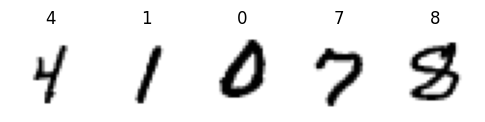

In [46]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

plt.figure(figsize=(6,3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)
for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
    break # just showing part of the first batch

In [ ]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = datasets["train"].repeat().prefetch(1)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)